In [1]:
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
from glob import glob
import os
import json
from time import time

In [2]:
train_data = glob('data/train/*')
test_data = glob('data/test/*')

print('train 데이터 수: ', len(train_data))
print('test 데이터 수: ', len(test_data))

train 데이터 수:  5767
test 데이터 수:  51906


# json 데이터 DataFrame 형태로 만들기

In [3]:
train_data_json = glob('data/train/*/*.json')

# 내 방식

In [4]:
descriptions = pd.DataFrame()
annotations = pd.DataFrame()
bbox = pd.DataFrame()
part = pd.DataFrame()

for data in train_data_json[0:1]:
    with open(data) as json_file:
        json_data = json.load(json_file)
    df = pd.DataFrame([json_data['description']])
    descriptions = pd.concat([descriptions, df])
    df = pd.DataFrame([json_data['annotations']])
    df = df.drop(['bbox', 'part'], axis = 1)
    annotations = pd.concat([annotations, df])
    df = pd.DataFrame(json_data['annotations']['bbox'])
    bbox = pd.concat([bbox, df])
    if len(json_data['annotations']['part']) == 0:
        df = pd.DataFrame(['Null'])
    else:
        df = pd.DataFrame(json_data['annotations']['part'])
    part = pd.concat([part, df])

In [4]:
for i, data in enumerate(train_data_json):
    with open(data) as f:
        json_file = json.load(f)
        
    json_file_re = {
      '주목객체': json_file['annotations']['bbox'],
      '병해부위': json_file['annotations']['part'],
      '촬영부위': json_file['annotations']['area'], 
      '작물': json_file['annotations']['crop'],
      '질병명': json_file['annotations']['disease'],
      '생육단계': json_file['annotations']['grow'],
      '피해정도': json_file['annotations']['risk'],
      '이미지id': json_file['description']['image'],
      '촬영날짜': json_file['description']['date'],
      '촬영시간': json_file['description']['time'],
      'height': json_file['description']['height'],
      'width': json_file['description']['width'],
      '촬영지역': json_file['description']['region'],
      '데이터종류': json_file['description']['task']
      }
    if i == 0:
        train_json_df = pd.json_normalize(json_file_re)
    else:
        train_json_df = train_json_df.append(pd.json_normalize(json_file_re))
        
tr_json_df = train_json_df.reset_index(drop=True)

In [5]:
tr_json_df.head()

,주목객체,병해부위,촬영부위,작물,질병명,생육단계,피해정도,이미지id,촬영날짜,촬영시간,height,width,촬영지역,데이터종류
0,"[{'x': 30.9711177765377, 'h': 472.937313988095...",[],3,2,00,13,0,38254.jpg,20211014,1058,512,384,0,0
1,"[{'x': 158.327375, 'h': 476.209875, 'y': 20.23...",[],3,4,00,13,0,21379.jpg,20211005,0745,512,682,0,0
2,"[{'x': 163.8089451058201, 'h': 406.09995039682...",[],3,6,00,24,0,29114.jpg,20210714,0846,512,682,0,0
3,"[{'x': 89.57142857142857, 'h': 402.42860243055...","[{'x': 93.42857142857143, 'h': 393.42860243055...",3,5,b6,13,1,51832.jpg,20211102,1138,512,384,0,2
4,"[{'x': 147.32130456349208, 'h': 333.9915054563...",[],3,3,00,12,0,65835.jpg,20210929,1100,512,384,0,0


In [6]:
# crop
crop_dict = {1 : '딸기',
             2 : '토마토',
             3 : '파프리카',
             4 : '오이', 
             5 : '고추',
             6 : '시설포도'
            }    
# risk
risk_dict = {0 : '정상',
             1 : '초기',
             2 : '중기',
             3 : '말기'}

task_dict = {0 : '정상',
             1 : '병해',
             2 : '생리장해',
            }## 보호제 처리 반응 삭제 tr_json_df['데이터종류'].unique() 3없음
# disease
disease_dict = {'00' : '정상',
                'a1' : '딸기잿빛곰팡이병-1',
                'a2' : '딸기흰가루병-1',
                'a3' : '오이노균병-1',
                'a4' : '오이흰가루병-1',
                'a5' : '토마토흰가루병-1',
                'a6' : '토마토잿빛곰팡이병-1',
                'a7' : '고추탄저병-1',
                'a8' : '고추흰가루병-1',
                'a9' : '파프리카흰가루병-1',
                'a10' : '파프리카잘록병-1',
                'a11' : '시설포도탄저병-1',
                'a12' : '시설포도노균병-1',
                'b1' : '냉해피해-2',
                'b2' : '열과-2',
                'b3' : '칼슘결핍-2',
                'b4' : '일소피해-2',
                'b5' : '축과병-2',
                'b6' : '다량원소결핍 (N)-2',
                'b7' : '다량원소결핍 (P)-2',
                'b8' : '다량원소결핍 (K)-2',
                # 'c1' : '딸기잿빛곰팡이병반응-2',
                # 'c2' : '딸기흰가루병반응-2',
                # 'c3' : '오이노균병반응-2',
                # 'c4' : '오이흰가루병반응-2',
                # 'c5' : '토마토흰가루병반응-2',
                # 'c6' : '토마토잿빛곰팡이병반응-2',
                # 'c7' : '고추탄저병반응-2',
                # 'c8' : '고추흰가루병반응-2',
                # 'c9' : '파프리카흰가루병반응-2',
                # 'c10' : '파프리카잘록병반응-2',
                # 'c11' : '시설포도탄저병반응-2',
                # 'c12' : '시설포도노균병반응-2'
               }

area_dict = {1 : '열매',
             2 : '꽃',
             3 : '잎',
             4 : '가지',
             5 : '줄기',
             6 : '뿌리',
             7 : '해충'}

grow_dict = {11: '유모기',
             12: '생장기',
             13: '착화/과실기',
             21: '발아기',
             22: '개화기',
             23: '신초생장기',
             24: '과실성숙기',
             25: '수확기',
             26: '휴먼기'}

In [7]:
tr_json_df['label_code'] =  tr_json_df['작물'].astype(str) + '_'  + tr_json_df['질병명'] + '_' + tr_json_df['피해정도'].astype(str)
print("train data에 존재하는 class 수: {}".format(tr_json_df['label_code'].nunique()))

tr_json_df['작물'] = tr_json_df['작물'].map(crop_dict) + '(' + tr_json_df['작물'].astype(str) + ')'
tr_json_df['질병명'] = tr_json_df['질병명'].map(disease_dict) + '(' + tr_json_df['질병명'].astype(str) + ')'
tr_json_df['피해정도'] = tr_json_df['피해정도'].map(risk_dict) + '(' + tr_json_df['피해정도'].astype(str) + ')'
tr_json_df['데이터종류'] = tr_json_df['데이터종류'].map(task_dict) + '(' + tr_json_df['데이터종류'].astype(str) + ')'
tr_json_df['촬영부위'] = tr_json_df['촬영부위'].map(area_dict) + '(' + tr_json_df['촬영부위'].astype(str) + ')'
tr_json_df['생육단계'] = tr_json_df['생육단계'].map(grow_dict) + '(' + tr_json_df['생육단계'].astype(str) + ')'

tr_json_df['label_name'] =  tr_json_df['작물'].astype(str) + '_'  + tr_json_df['질병명'] + '_' + tr_json_df['피해정도'].astype(str)

train data에 존재하는 class 수: 25


In [8]:
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

rc('font', family = 'AppleGothic')

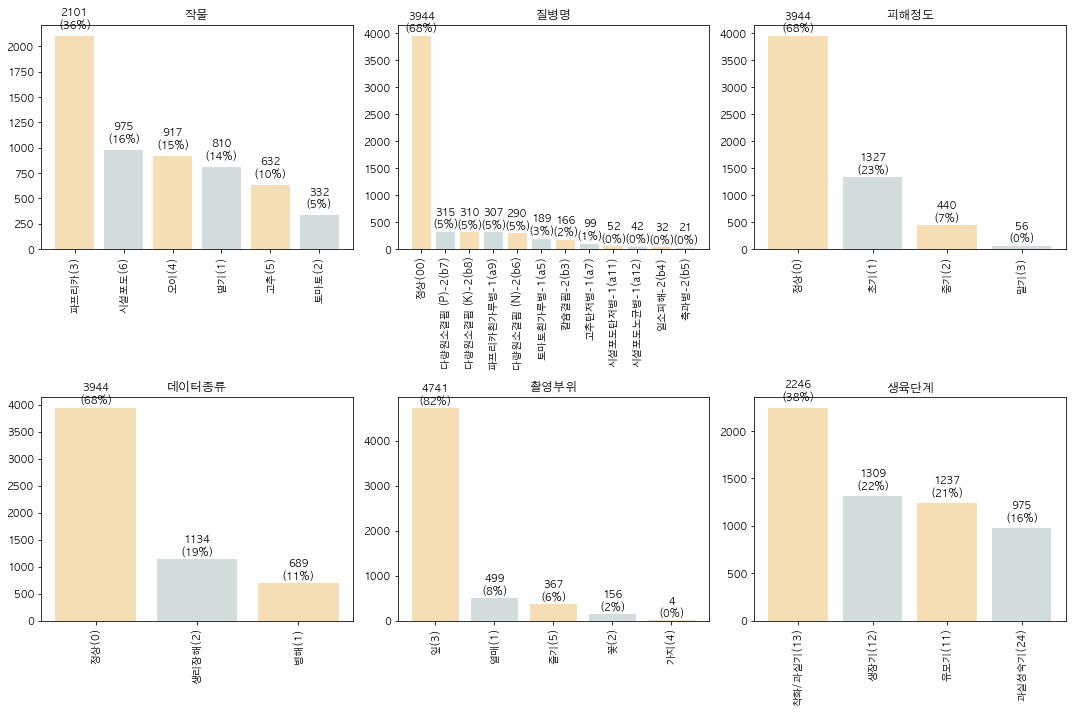

In [9]:
f, axs = plt.subplots(2,3, figsize= (15,10))
axs = axs.flatten()

for i, col in enumerate(['작물', '질병명', '피해정도', '데이터종류', '촬영부위', '생육단계' ]):
    object_cnt = tr_json_df[col].value_counts().sort_values(ascending = False)
    axs[i].bar(object_cnt.index, object_cnt.values, color = ['#d4dddd' if i%2 else '#F5DEB3' for i in range(10)])
    for x, y, z in zip(object_cnt.index, object_cnt.values, (object_cnt.values / object_cnt.sum())*100 ):
        axs[i].annotate('%d\n(%d%%)'%(int(y),z), xy = (x,y + 70), ha = 'center')
    axs[i].set_xticklabels(object_cnt.index, rotation = 90)
    axs[i].set_title(col)

plt.tight_layout()

Text(0.5, 1.0, 'label_name')

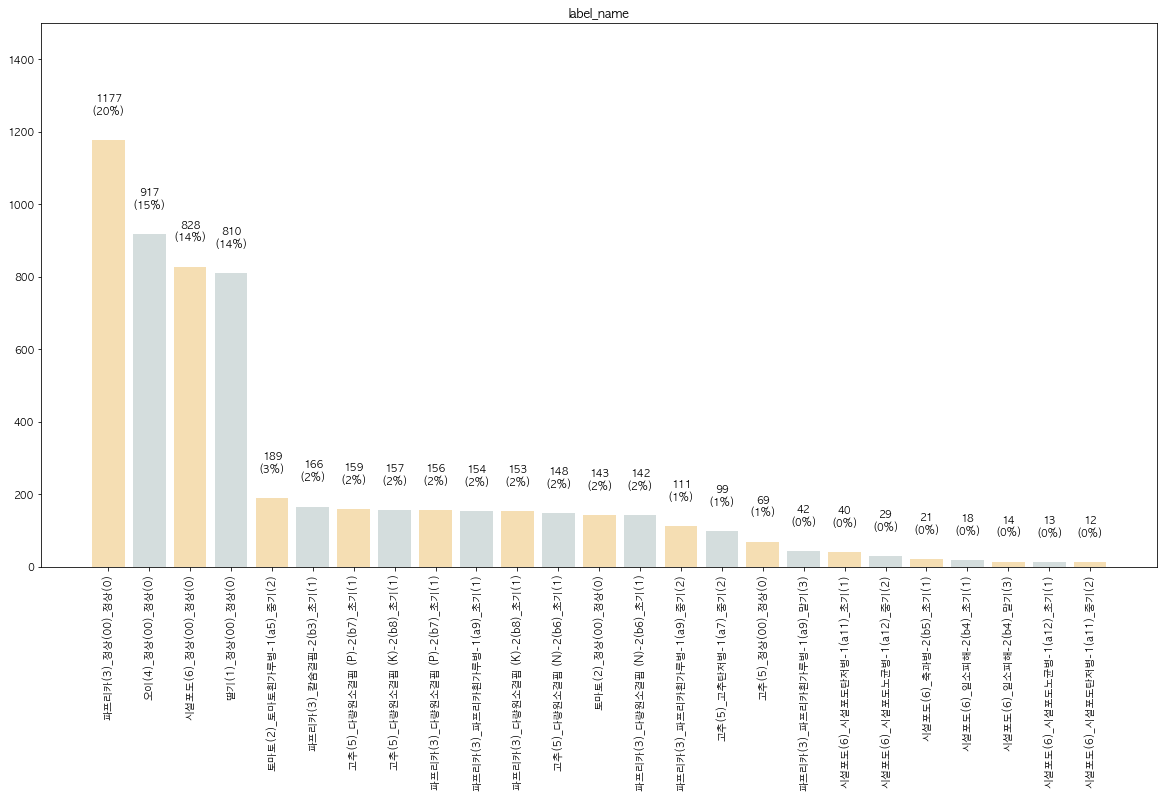

In [10]:
plt.figure(figsize = (20, 10))
col = 'label_name'

object_cnt = tr_json_df[col].value_counts().sort_values(ascending = False)
plt.bar(object_cnt.index, object_cnt.values, color = ['#d4dddd' if i%2 else '#F5DEB3' for i in range(25)])
for x, y, z in zip(object_cnt.index, object_cnt.values, (object_cnt.values / object_cnt.sum())*100):
    plt.annotate('%d\n(%d%%)' %(int(y), z), xy = (x, y + 70), ha = 'center')
plt.xticks(object_cnt.index, rotation = 90)
plt.ylim(0, 1500)
plt.title('label_name')

-----

# 작물에 따른 질병명과 질병명에 따른 피해정도

In [11]:
temp = tr_json_df.groupby('작물')['질병명'].value_counts().rename('cnt').reset_index()
temp1 = tr_json_df.groupby('질병명')['피해정도'].value_counts().rename('cnt').reset_index()

In [12]:
i = 0
temp_dict = {}

for c_list in [temp['작물'].unique(), temp['질병명'].unique(), temp1['피해정도'].unique()]:
    for item in c_list:
        temp_dict[item] = i
        i += 1

In [13]:
import plotly.io as pio
import plotly.graph_objects as go
pio.renderers.default = 'notebook_connected'

NODES = dict(label = list(temp_dict.keys()))

LINKS =  dict(source = list(temp['작물'].map(temp_dict).values) + list(temp1['질병명'].map(temp_dict).values),

target = list(temp['질병명'].map(temp_dict).values) + list(temp1['피해정도'].map(temp_dict).values),

value = list(temp['cnt'].values) + list(temp1['cnt'].values)
             )

data = go.Sankey(node = NODES, link = LINKS)
fig = go.Figure(data)
fig.show()

------

# 작물 월별, 월별 질병 

In [14]:
tr_json_df['Month'] = tr_json_df['촬영날짜'].apply(lambda x : x[4:6])

In [15]:
temp = tr_json_df.groupby('작물')['Month'].value_counts().rename('cnt').reset_index()
temp1 = tr_json_df.groupby('Month')['질병명'].value_counts().rename('cnt').reset_index()

In [16]:
i = 0
temp_dict = {}

for c_list in [temp['작물'].unique(), temp['Month'].unique(), temp1['질병명'].unique()]:
    for item in c_list:
        temp_dict[item] = i
        i += 1

In [17]:
NODES = dict(label = list(temp_dict.keys()))

LINKS = dict(source = list(temp['작물'].map(temp_dict).values) + list(temp1['Month'].map(temp_dict).values),

target = list(temp['Month'].map(temp_dict).values) + list(temp1['질병명'].map(temp_dict).values),

value = list(temp['cnt'].values) + list(temp1['cnt'].values)

)

data = go.Sankey(node = NODES, link =  LINKS)
fig = go.Figure(data)
fig.show()

-----------

# 작물별 잎의 모양 비교

In [18]:
tr_json_df['주목객체'].iloc[0][0]

{'x': 30.9711177765377,
 'h': 472.93731398809524,
 'y': 0.0,
 'w': 310.54823908730157}

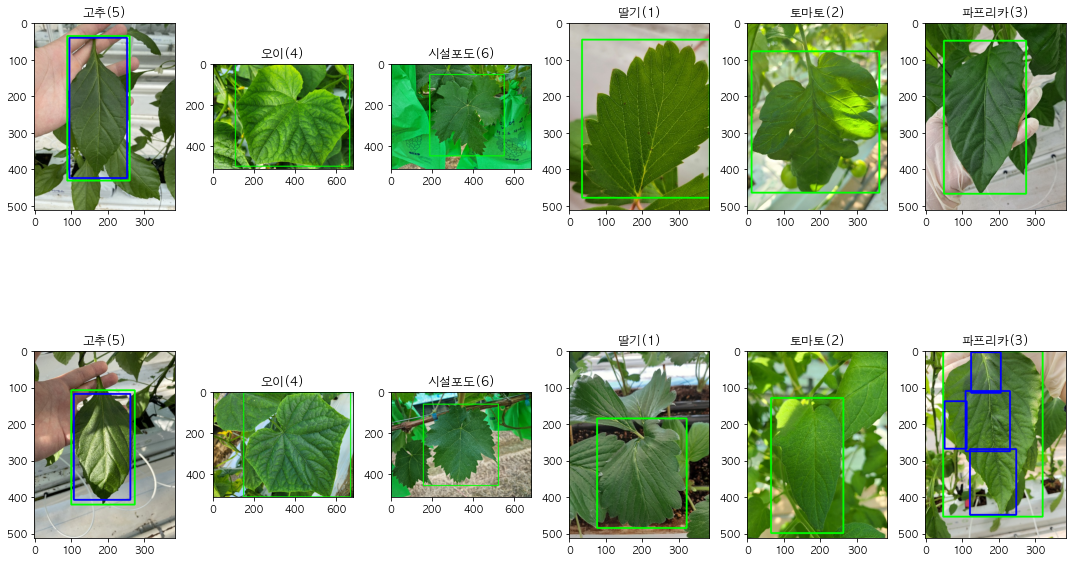

In [19]:
fig, ax = plt.subplots(2, 6, figsize= (15,10))
ax = ax.flatten()
crops = ['고추(5)', '오이(4)', '시설포도(6)', '딸기(1)', '토마토(2)', '파프리카(3)']

for i, name in enumerate(crops*2):
    tmp = tr_json_df.loc[(tr_json_df['촬영부위'] == '잎(3)')&(tr_json_df['작물'] == name)].sample(1)
    path = 'data/train/' + tmp['이미지id'].iloc[0].split('.')[0] + '/' + tmp['이미지id'].iloc[0].split('.')[0] + '.jpg'
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    points = tmp['주목객체'].iloc[0][0]
    ill_points = tmp['병해부위'].iloc[0]
    cv2.rectangle(img, 
                  (int(points['x']), int(points['y'])), 
                  (int(points['x'] + points['w']), int(points['y'] + points['h'])), 
                  (0, 255, 0), # green_color 
                  3)
    
    for ill_point in ill_points:
        cv2.rectangle(img, 
                  (int(ill_point['x']), int(ill_point['y'])), 
                  (int(ill_point['x'] + ill_point['w']), int(ill_point['y'] + ill_point['h'])), 
                  (0, 0, 255), # red_color
                  3)
    
    
    ax[i].imshow(img)
    ax[i].set_title(name)
    
plt.tight_layout()
plt.show()

# 병에 따른 질병 비교

In [31]:
illnesses = tr_json_df['질병명'].unique()
n_illnesses = len(illnesses)

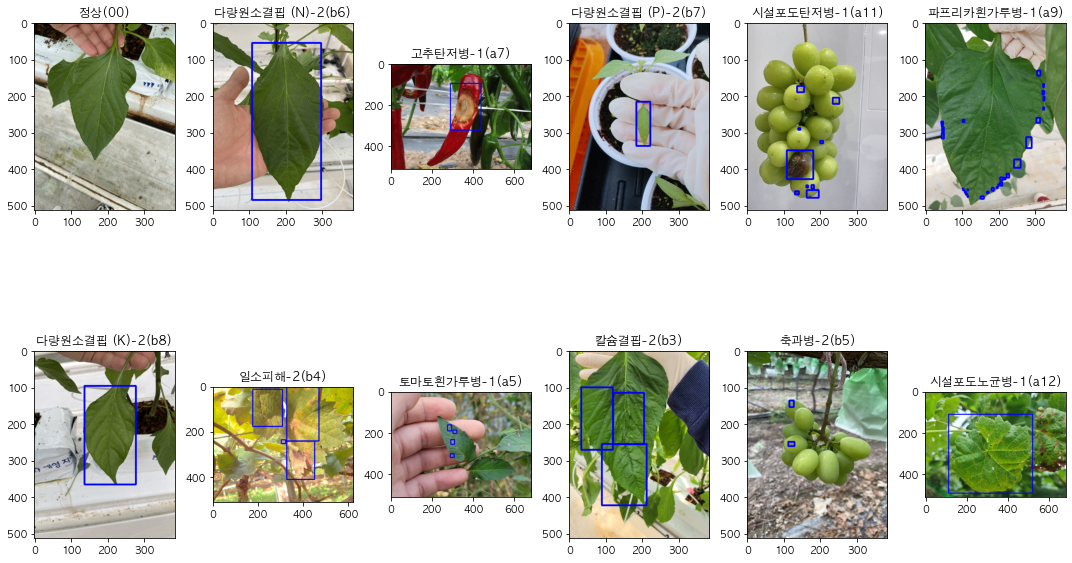

In [60]:
fig, ax = plt.subplots(2, int(n_illnesses /2), figsize = (15, 10))
ax = ax.flatten()

for i, illness in enumerate(illnesses):
    tmp = tr_json_df.loc[tr_json_df['질병명'] == illness].sample(1)
    path = 'data/train/' + tmp['이미지id'].iloc[0].split('.')[0] + '/' + tmp['이미지id'].iloc[0].split('.')[0] + '.jpg'
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    ill_points = tmp['병해부위'].iloc[0]
    
    for point in ill_points:
        cv2.rectangle(img, (int(point['x']), int(point['y'])), 
                      (int(point['x'] + point['w']),int(point['y'] + point['h'])),
                    (0,0,255), 3)
    
    ax[i].imshow(img)
    ax[i].set_title(illness)
    
plt.tight_layout()
plt.show()

In [61]:
tr_json_df.columns

Index(['주목객체', '병해부위', '촬영부위', '작물', '질병명', '생육단계', '피해정도', '이미지id', '촬영날짜',
       '촬영시간', 'height', 'width', '촬영지역', '데이터종류', 'label_code', 'label_name',
       'Month'],
      dtype='object')

# 파프리카 흰가루병 피해정도 비교 

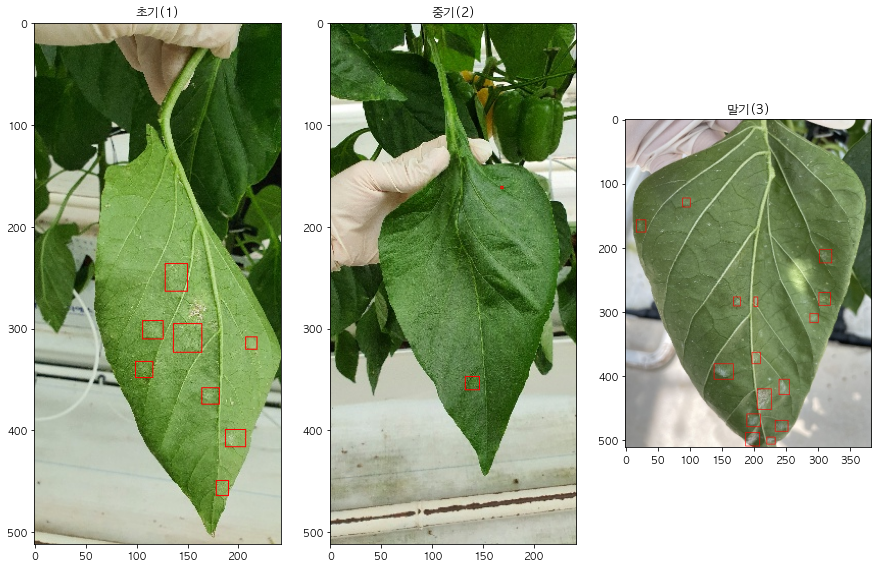

In [126]:
fig, ax = plt.subplots(1, 3, figsize = (15, 10))

stages = tr_json_df['피해정도'].unique()

for i, stage in enumerate(stages[1:]):
    temp = tr_json_df.loc[(tr_json_df['질병명'] == '파프리카흰가루병-1(a9)')&(tr_json_df['피해정도'] == stage)].sample(1)
    path = 'data/train/' + temp['이미지id'].iloc[0].split('.')[0] + '/' + temp['이미지id'].iloc[0].split('.')[0] + '.jpg'
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    ill_points = temp['병해부위'].iloc[0]
    
    for point in ill_points:
        cv2.rectangle(img, (int(point['x']), int(point['y'])), 
                      (int(point['x'] + point['w']), int(point['y'] + point['h'])),
                     (255,0,0), 1)
    
    
    ax[i].imshow(img)
    ax[i].set_title(stage)
    
    